In [46]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
warnings.filterwarnings('ignore')
import time as timer
start_all = timer.time()

In [47]:
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
#datao ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/data/era/" 
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"

In [48]:
#For selection and plotting
Y1, Y2 = 2000,2000
time_bnds = (str(Y1)+'-01-01',str(Y2)+'-12-31')
lon_bnds, lat_bnds = (15, 30), (5,-10)
#p_bnds = (1000,300) #for daily folder files
p_bnds = (30000,100000)

Read in ERA5 data on pressure levels (hourly in fortnightly files)
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)

In [49]:
start = timer.time()
from functools import partial
def _preprocess_pres(x, lon_bnds, lat_bnds, p_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds),
                 plev=slice(*p_bnds),drop=True)
partial_func_pres = partial(_preprocess_pres, lon_bnds=lon_bnds, lat_bnds=lat_bnds, p_bnds=p_bnds)

#Reading in pressure level variables from ERA5
ds_era_pres = xr.open_mfdataset(dataf+"era5/pressure_levels/era5_pressure_level_variables_central_africa_"+str(Y1)+"*.nc",
                                drop_variables=['r','t','w'],
                                preprocess=partial_func_pres,parallel=True).resample(time='MS').mean(dim='time').load()
ds_era_pres = ds_era_pres.sel(time=slice(*time_bnds),drop=True)
ds_era_pres = ds_era_pres.rename({'plev':'level','q':'Shum','u':'Uwnd','v':'Vwnd'})
ds_era_pres['Shum'] = 1000.0*ds_era_pres['Shum']
ds_era_pres['level'] = ds_era_pres['level']/100.0 #for half monthly files only 
ds_era_pres = ds_era_pres.sortby('level', ascending=False) #for half monthly files only
end = timer.time()
length = end - start
print("ERA5 pressure level data read in took ", length, "seconds")

ERA5 pressure level data read in took  848.8392832279205 seconds


Read in ERA5 land data (hourly in monthly files)
- resampling to daily first because evap and prec need to be summed rather than averaged at the daily scale (mm/day) while surface pressure is averaged
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- then resampled to MS monthly and also interpolated to coarser pressure level grid

In [50]:
start = timer.time()
from functools import partial
def _preprocess_land(x, lon_bnds, lat_bnds):
    x = x.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds),drop=True)
    return x
partial_func_land = partial(_preprocess_land, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

#Reading in surface variables from ERA5 Land
ds_era_land = xr.open_mfdataset("/Volumes/ESA_F4R/era/era5_land/era5_land_variables_central_africa_"+str(Y1)+"*.nc",
                                drop_variables=['expver','number','pev','ssr','t2m'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_land = ds_era_land.sel(valid_time=slice(*time_bnds),drop=True)
ds_era_land = ds_era_land.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','tp':'Prec','e':'Evap','sp':'Psfc'})
ds_era_land = ds_era_land.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
#print('era after int before resample',ds_era_land)
Psfc = ds_era_land['Psfc'].resample(time='D').mean(dim='time')
ds_era_land = ds_era_land.resample(time='D').sum(dim='time')
ds_era_land['Psfc'] = Psfc/100.0
ds_era_land['Prec'] = ds_era_land['Prec']*1000.0 
ds_era_land['Evap'] = ds_era_land['Evap']*-1000.0 
ds_era_land = ds_era_land.resample(time='MS').mean(dim='time')
end = timer.time()
length = end - start
print("ERA5 land data read in took ", length, "seconds")

ERA5 land data read in took  69.29038286209106 seconds


Merging the two datasets into one dataset for recyling code called ds
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

In [51]:
start = timer.time()
ds = xr.merge([ds_era_pres,ds_era_land]) 
ds_era_pres.close()
ds_era_land.close()
ds = ds.sortby('lat', ascending=True)
ds = ds.transpose("lon", "lat", "level", "time",missing_dims='ignore')
ds.to_netcdf(datao+"erads_"+str(Y1)+".nc", mode='w', format='NETCDF4', engine='netcdf4')
end = timer.time()
length = end - start
print("Merging and dataset output took ", length, "seconds")

Merging and dataset output took  1.0151219367980957 seconds


In [52]:
#ds = ds.sel(lat=slice(-1,1),lon=slice(20,22))
#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

In [53]:
# Prepare and scale the data
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

print("prepping data for recycling - scaling and flux calcs etc")

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
#print('pre-scaled',ds['Evap'])
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

prepping data for recycling - scaling and flux calcs etc
L = 1.66e+06 m
dx = 2.73e+04 m
H = 1.66e+06 m
dy = 2.73e+04 m
dx = 1.64e-02 scaled
dy = 1.64e-02 scaled


- Create recycling output array based on the shape of one of the surface input files: evap (E)
- Run through each timestep in the input files and calculate recycling ratio at each timestep across domain

INFO:bulk_recycling_model.main:Converged in 141 iterations and 0:00:01.309247


0 2000-01-01T00:00:00.000000000
141


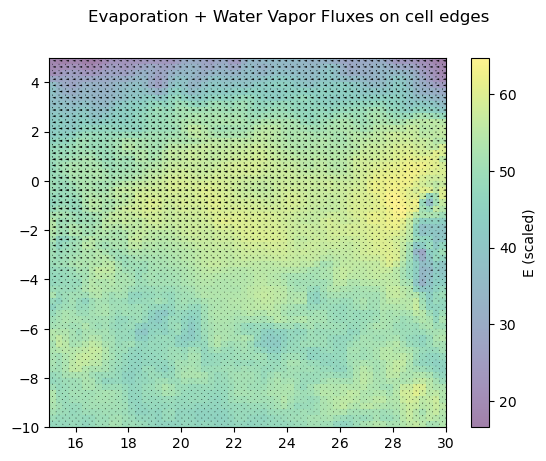

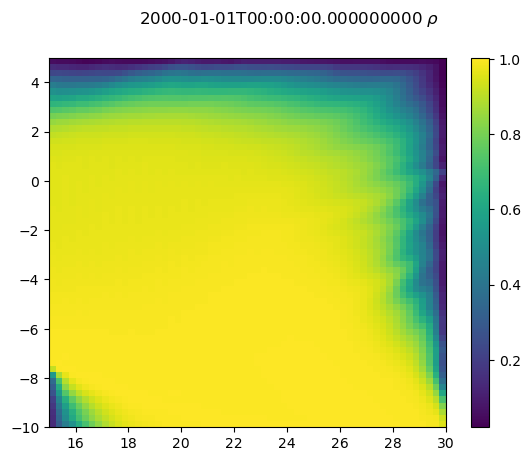

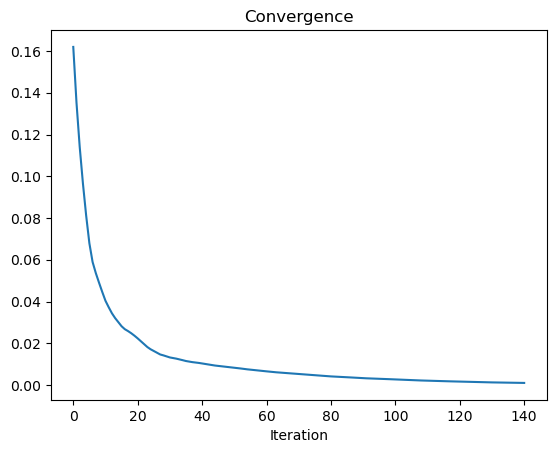

INFO:bulk_recycling_model.main:Converged in 118 iterations and 0:00:01.109580


1 2000-02-01T00:00:00.000000000
118


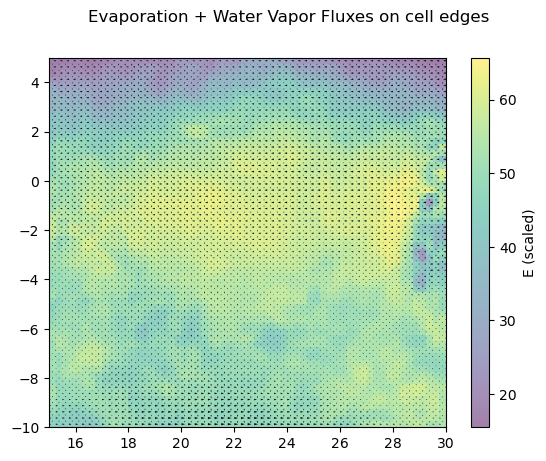

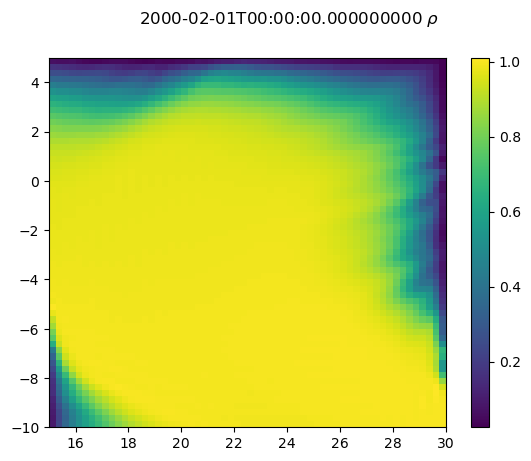

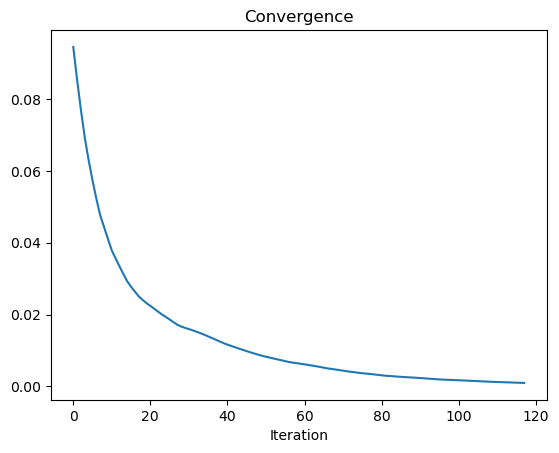

INFO:bulk_recycling_model.main:Converged in 127 iterations and 0:00:01.163994


2 2000-03-01T00:00:00.000000000
127


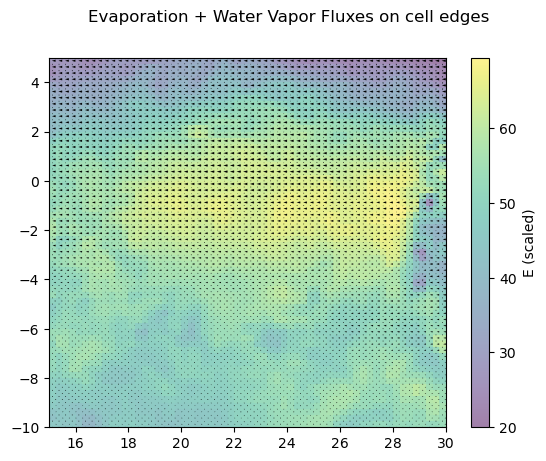

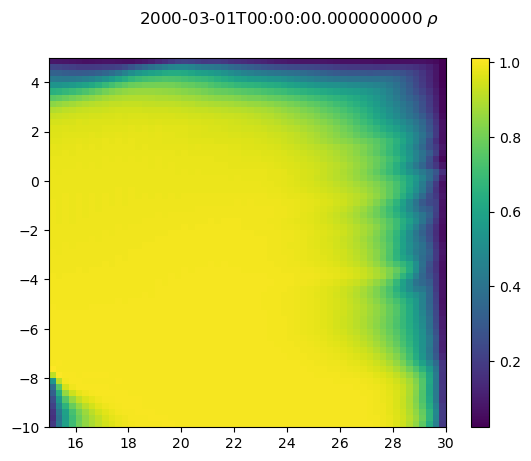

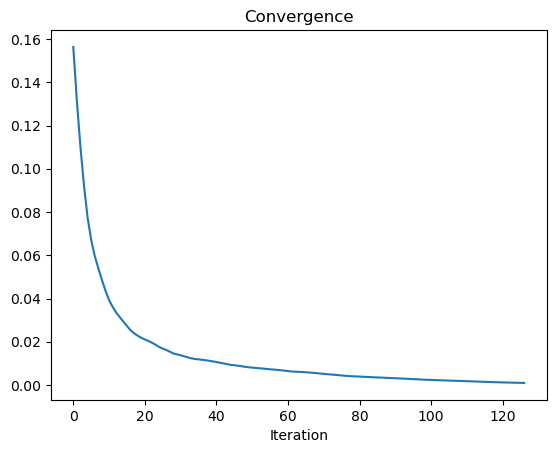

INFO:bulk_recycling_model.main:Converged in 136 iterations and 0:00:01.233233


3 2000-04-01T00:00:00.000000000
136


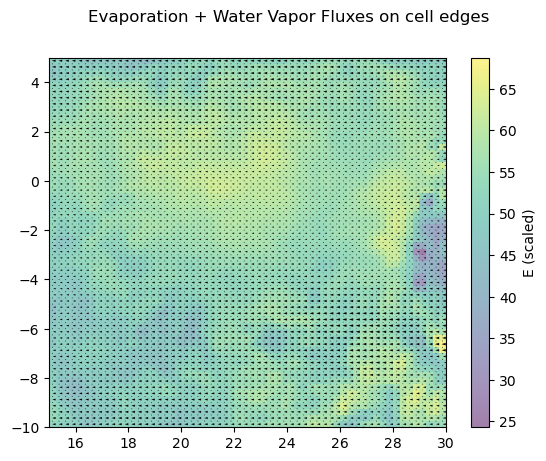

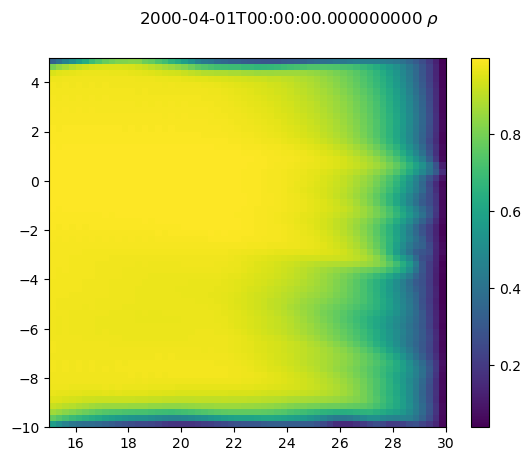

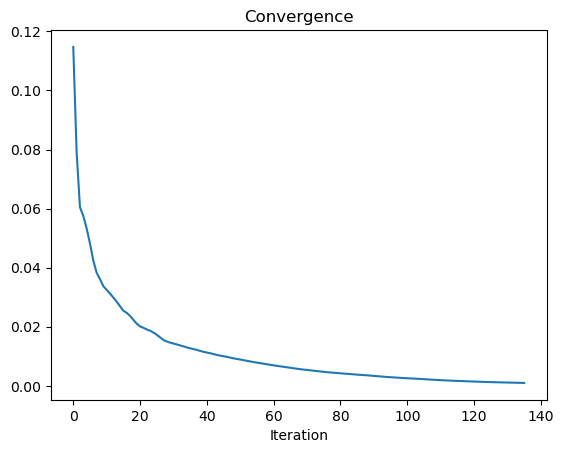

INFO:bulk_recycling_model.main:Converged in 145 iterations and 0:00:01.421817


4 2000-05-01T00:00:00.000000000
145


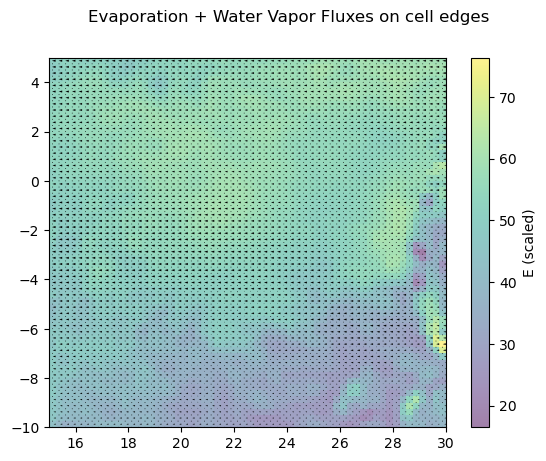

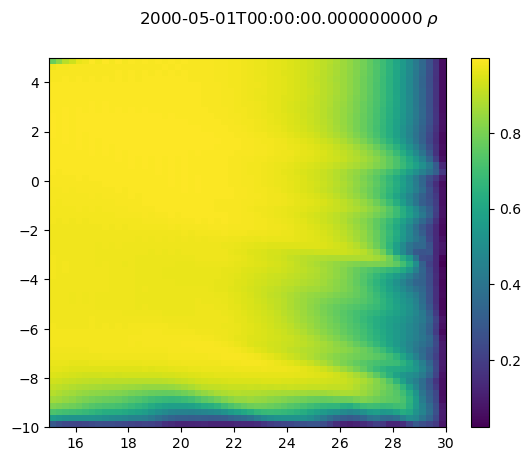

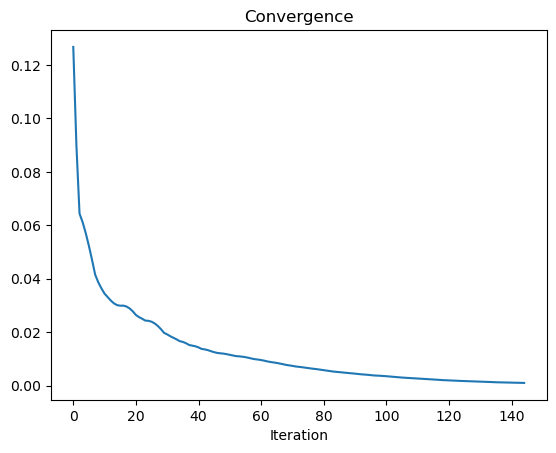

INFO:bulk_recycling_model.main:Converged in 154 iterations and 0:00:01.430815


5 2000-06-01T00:00:00.000000000
154


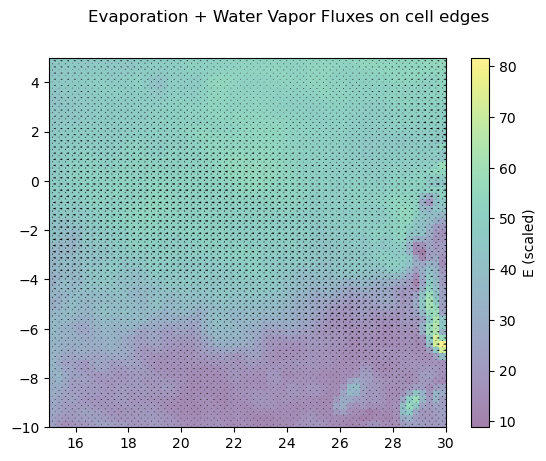

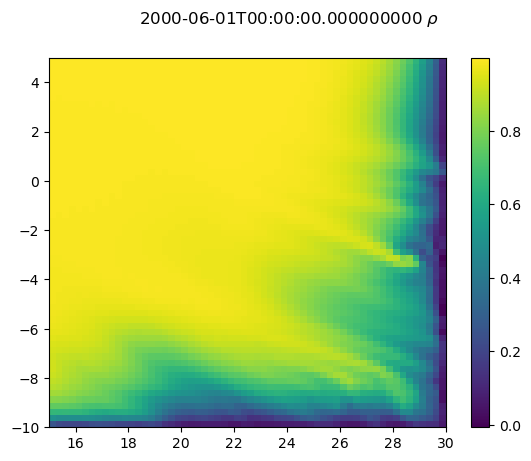

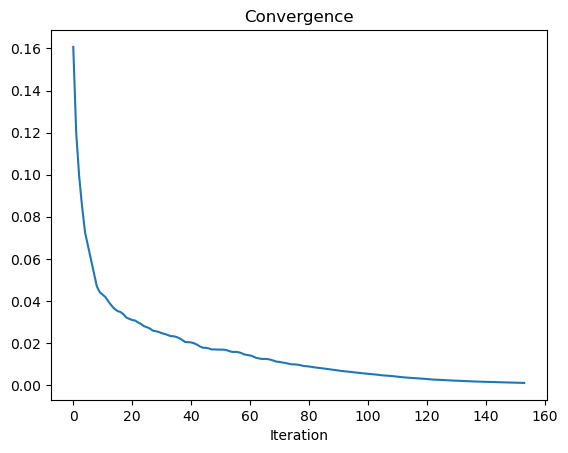

INFO:bulk_recycling_model.main:Converged in 152 iterations and 0:00:01.393030


6 2000-07-01T00:00:00.000000000
152


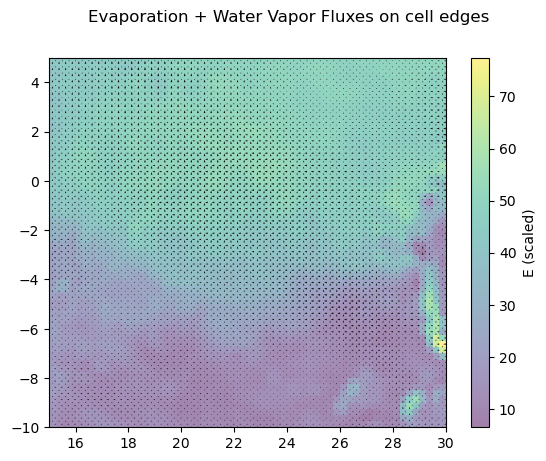

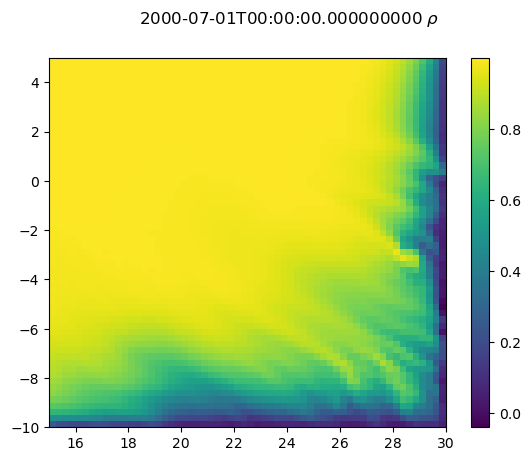

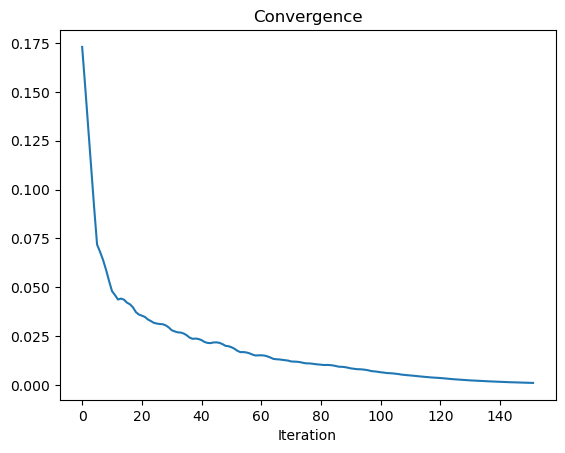

INFO:bulk_recycling_model.main:Converged in 157 iterations and 0:00:01.465132


7 2000-08-01T00:00:00.000000000
157


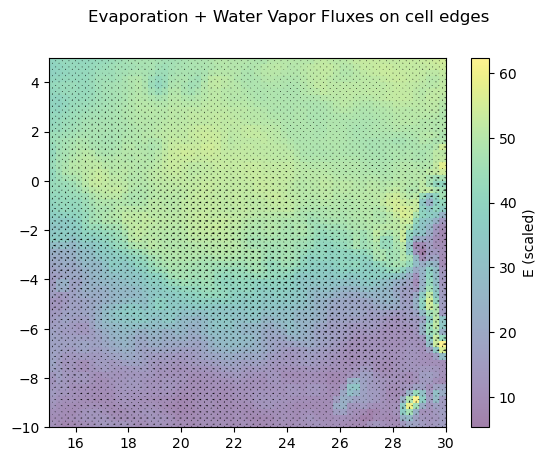

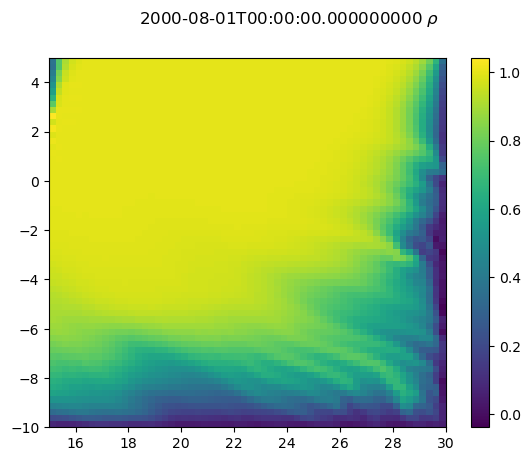

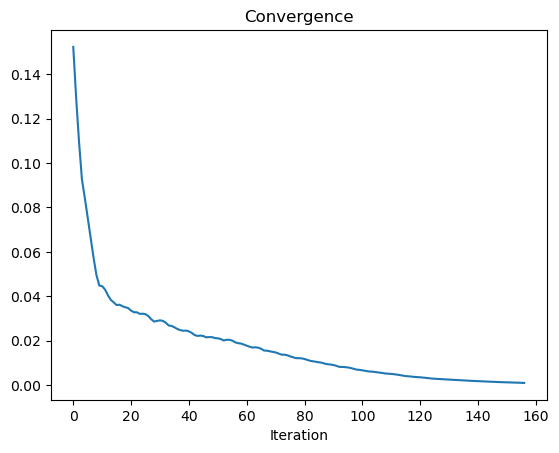

INFO:bulk_recycling_model.main:Converged in 151 iterations and 0:00:01.373683


8 2000-09-01T00:00:00.000000000
151


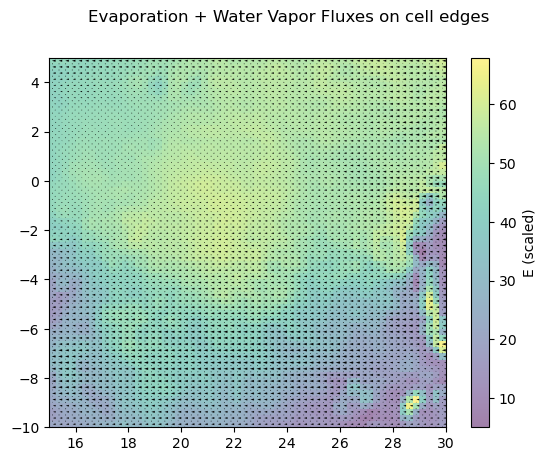

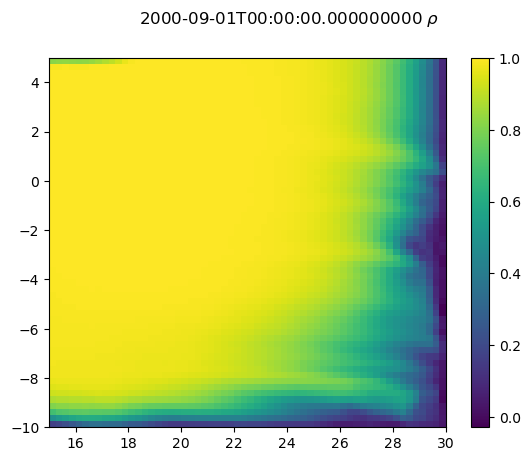

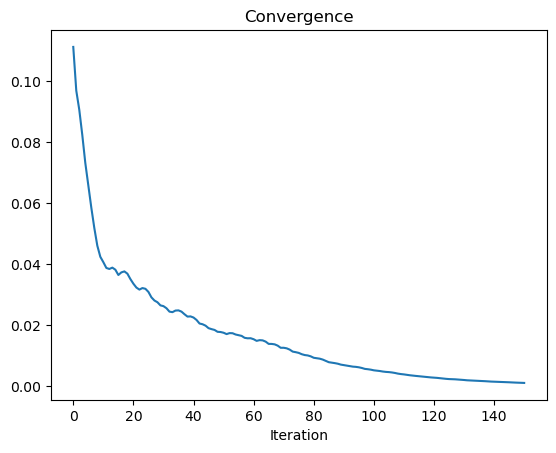

INFO:bulk_recycling_model.main:Converged in 118 iterations and 0:00:01.146096


9 2000-10-01T00:00:00.000000000
118


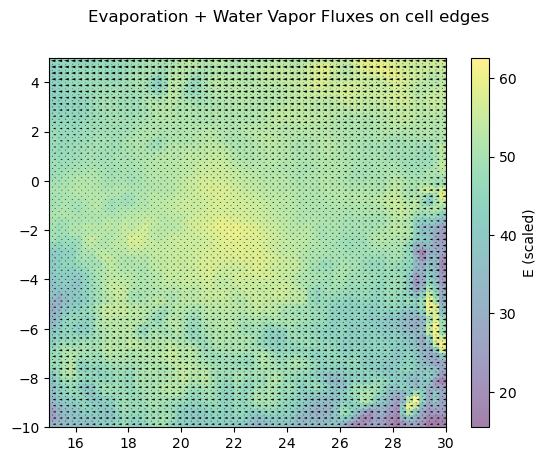

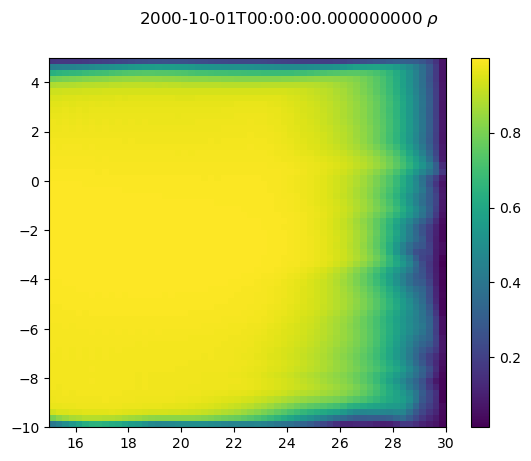

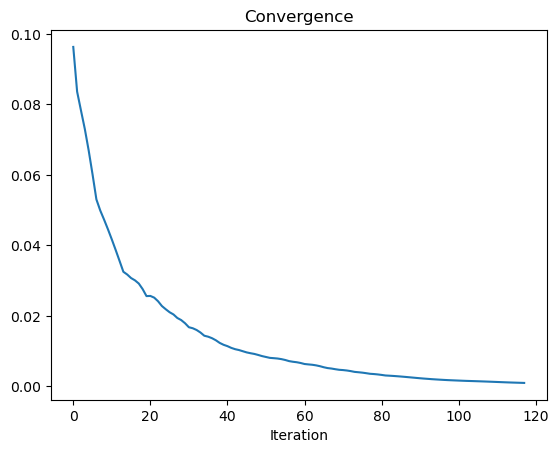

INFO:bulk_recycling_model.main:Converged in 148 iterations and 0:00:01.360585


10 2000-11-01T00:00:00.000000000
148


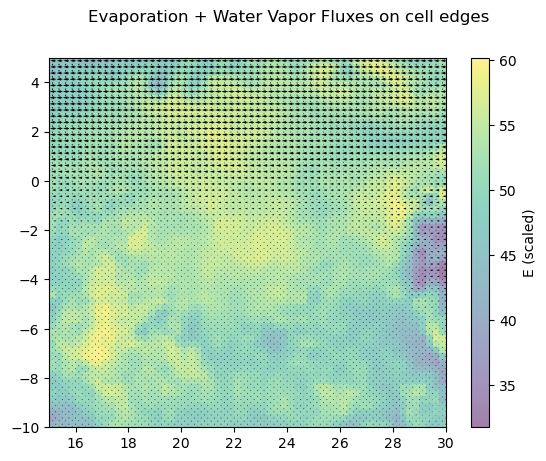

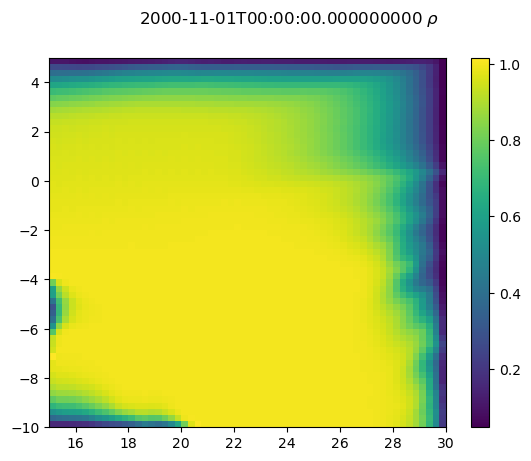

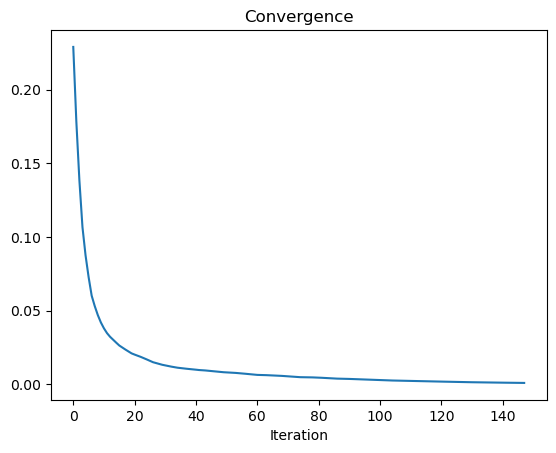

INFO:bulk_recycling_model.main:Converged in 147 iterations and 0:00:01.373155


11 2000-12-01T00:00:00.000000000
147


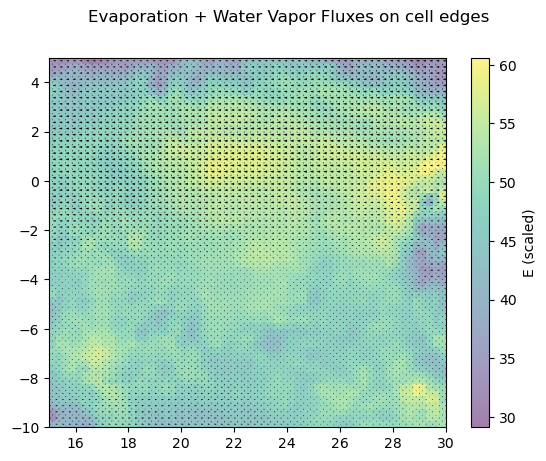

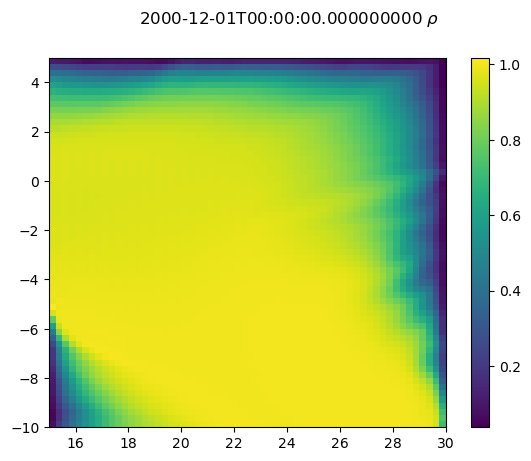

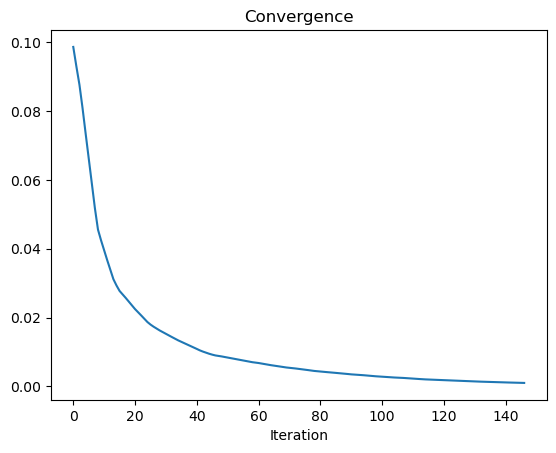

In [54]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

rho_ar = np.empty((np.shape(E)[0]-1,np.shape(E)[1]-1,np.shape(E)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
     
    # preprocess E onto the secondary grid
    Ei = preprocess.prepare_E(E[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei, dx, dy)

#    # Create a quiver plot
#    fig, ax = plt.subplots()
#    #X, Y = np.meshgrid(lon_axis.secondary, lat_axis.secondary, indexing="ij")
#    #collection = ax.pcolormesh(X[::3,::3], Y[::3,::3], Ei[::3,::3], alpha=0.5)
#    #fig.colorbar(collection, label="E (scaled)")
#    U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
#    X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
#    ax.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
#    fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # Run the model
    status = run(
        Fxi_left,
        Fxi_right,
        Fyi_bottom,
        Fyi_top,
        Ei,
        Pi,
        dx,
        dy,
        max_iter=500,
        tol=1e-3,
    )

    #Print timestep and status (converged or not) and add rho to recycling ration array
    print(i,time.values)
    print(status['k'])
    rho_ar[:,:,i] = status["rho"]

    # plot each timestep 
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, status["rho"], lon_axis, lat_axis)
                                     #vmin=0.0, vmax=0.8)
    fig.colorbar(collection)
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    
    # plot the convergence
    deltas = status["deltas"]
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_title("Convergence")
    ax.set_xlabel("Iteration")
    plt.show()
    plt.close()

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Save to file

In [55]:
lon_ar = np.linspace(start=ds.coords["lon"].min().values+lon_axis.step/2,
                     stop=ds.coords["lon"].max().values-lon_axis.step/2,
                     num=lon_axis.n_points-1)
lat_ar = np.linspace(start=ds.coords["lat"].min().values+lat_axis.step/2,
                     stop=ds.coords["lat"].max().values-lat_axis.step/2,
                     num=lat_axis.n_points-1)
rho_xarr = xr.DataArray(
    data=rho_ar,
    dims=["lon", "lat", "time"],
    coords=dict(
        lon=(["lon"], lon_ar),
        lat=(["lat"], lat_ar),
        time=(["time"],ds.time.data)
    ),
    attrs=dict(
        description="Recycling ratio",
        units="%",
    ),
) 
rho_xarr = rho_xarr.transpose("time","lat","lon")
print('Number of rhos over 1: ', rho_xarr.where(rho_xarr.values>1.0).count().values)
#rho_xarr = rho_xarr.where(rho_xarr.values<=1.0,1.0)
print('Number of rhos over 1: ', rho_xarr.where(rho_xarr.values>1.0).count().values)
rho_xarr.to_netcdf(datao+"rho_era5_"+str(Y1)+".nc")

end_all = timer.time()
length = end_all - start_all
print("Running the whole prep and recycling code took ", length, "seconds")

Number of rhos over 1:  260
Number of rhos over 1:  260
Running the whole prep and recycling code took  940.3897378444672 seconds


Create seasonal arrays and plot these

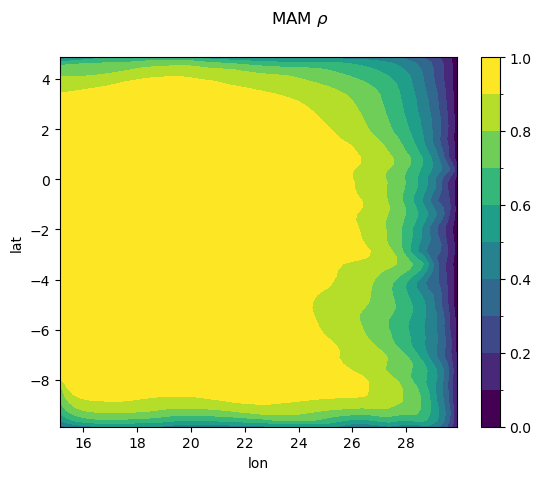

In [56]:

mam_rho = rho_xarr.sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
fig, ax = plt.subplots()
#collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.75,levels=12,ax=ax)
collection = mam_rho.mean("time").plot.contourf(levels=12,ax=ax)
fig.suptitle("MAM $\\rho$")
plt.savefig(datao+"rho_MAM_"+str(Y1)+".png")
plt.show()
    
#son_rho = rho_xarr.sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
#print(son_rho)    
#fig, ax = plt.subplots()
#collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.75,levels=12,ax=ax)
#fig.suptitle("SON $\\rho$")
##plt.savefig(datap+"rho_SON"+str(year1)+"_"+str(year2)+".png")
#plt.show()
#
#jja_rho = rho_xarr.sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
#print(jja_rho)    
#fig, ax = plt.subplots()
#collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.75,levels=12,ax=ax)
#fig.suptitle("JJA $\\rho$")
##plt.savefig(datap+"rho_JJA"+str(year1)+"_"+str(year2)+".png")
#plt.show()

